In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

In [2]:
df_base = pd.json_normalize(list(json.loads(line) for line in open("/tmp/stellarpunk_test.history", "r")))

In [3]:
df_base["eid"].unique()

array(['55c171b7-e136-4e53-a3c0-c8aa6d141766',
       '476aff9b-6e48-41ca-8bbd-4416583848e4',
       '1b50c8e6-c01e-4cca-b58e-1add4d084a4b'], dtype=object)

In [4]:
target_eid = df_base["eid"].unique()[0]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['55c171b7-e136-4e53-a3c0-c8aa6d141766'], dtype=object)

In [5]:
df_base

,index,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,o.t_v,o.cs,o.ct,o.ct_loc,o.ct_ts,o.ct_dv,o.cac,o.cbdr,o
0,0,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.000000,"[33792.19441462345, -2817.1195386229265]",0.674026,"[-1516.455517907544, -865.0005079951259]",1.430231,stellarpunk.orders.GoToLocation,16921.316914,"[19117.170259352486, -11241.763871430074]","[-1414.9491325226845, -812.2946214188033]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.016667,"[33766.92015599166, -2831.5362137561788]",0.697863,"[-1512.7576272422318, -863.0804257733166]",1.413564,stellarpunk.orders.GoToLocation,16892.220141,"[19117.170259352486, -11241.763871430074]","[-1415.5272469447457, -812.6354706694898]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.033333,"[33741.70752887096, -2845.9208875190675]",0.721423,"[-1512.720642010481, -863.0612371375274]",1.396898,stellarpunk.orders.GoToLocation,16863.192751,"[19117.170259352486, -11241.763871430074]","[-1416.111357435253, -812.9794731721403]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.050000,"[33716.495518170785, -2860.3052414713597]",0.744704,"[-1512.6836503703785, -863.0420608585968]",1.380231,stellarpunk.orders.GoToLocation,16834.166055,"[19117.170259352486, -11241.763871430074]","[-1416.6972683694787, -813.3245431217559]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.066667,"[33691.284123997946, -2874.689275819003]",0.767708,"[-1512.6466522221758, -863.0228971392113]",1.363564,stellarpunk.orders.GoToLocation,16805.140054,"[19117.170259352486, -11241.763871430074]","[-1417.2849871555618, -813.6706849489641]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,818,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.633333,"[19890.798656045547, -10774.249160091329]",0.544035,"[-14.154095204818212, -8.553522288255806]",0.000000,stellarpunk.orders.GoToLocation,903.919743,"[19117.170259352486, -11241.763871430074]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,819,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.650000,"[19890.5627544588, -10774.391718796132]",0.544035,"[-10.588013505157935, -6.398488083780347]",0.000000,stellarpunk.orders.GoToLocation,903.644112,"[19117.170259352486, -11241.763871430074]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
820,820,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.666667,"[19890.386287567046, -10774.498360264195]",0.544035,"[-7.021931805497658, -4.243453879304887]",0.000000,stellarpunk.orders.GoToLocation,903.437925,"[19117.170259352486, -11241.763871430074]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,821,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.683333,"[19890.269255370287, -10774.569084495517]",0.544035,"[-3.455850105837381, -2.088419674829428]",0.000000,stellarpunk.orders.GoToLocation,903.301183,"[19117.170259352486, -11241.763871430074]","[0.0, 0.0]",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)

In [8]:
df

,index,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,...,o.t_loc.x,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed
0,0,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.000000,"[33792.19441462345, -2817.1195386229265]",0.674026,"[-1516.455517907544, -865.0005079951259]",1.430231,stellarpunk.orders.GoToLocation,16921.316914,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1414.949133,-812.294621,78.131508,62.413680,1.745813e+03,NaN,16921.316914,1631.534125
1,1,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.016667,"[33766.92015599166, -2831.5362137561788]",0.697863,"[-1512.7576272422318, -863.0804257733166]",1.413564,stellarpunk.orders.GoToLocation,16892.220141,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1415.527247,-812.635471,76.621686,64.258208,1.741650e+03,NaN,16892.220141,1632.205194
2,2,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.033333,"[33741.70752887096, -2845.9208875190675]",0.721423,"[-1512.720642010481, -863.0612371375274]",1.396898,stellarpunk.orders.GoToLocation,16863.192751,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1416.111357,-812.979473,75.086677,66.045370,1.741608e+03,NaN,16863.192751,1632.883033
3,3,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.050000,"[33716.495518170785, -2860.3052414713597]",0.744704,"[-1512.6836503703785, -863.0420608585968]",1.380231,stellarpunk.orders.GoToLocation,16834.166055,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1416.697268,-813.324543,73.528823,67.775454,1.741566e+03,NaN,16834.166055,1633.562966
4,4,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.066667,"[33691.284123997946, -2874.689275819003]",0.767708,"[-1512.6466522221758, -863.0228971392113]",1.363564,stellarpunk.orders.GoToLocation,16805.140054,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1417.284987,-813.670685,71.950410,69.448819,1.741525e+03,NaN,16805.140054,1634.244999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,818,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.633333,"[19890.798656045547, -10774.249160091329]",0.544035,"[-14.154095204818212, -8.553522288255806]",0.000000,stellarpunk.orders.GoToLocation,903.919743,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,0.000000,0.000000,85.562729,51.759244,1.653787e+01,NaN,903.919743,0.000000
819,819,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.650000,"[19890.5627544588, -10774.391718796132]",0.544035,"[-10.588013505157935, -6.398488083780347]",0.000000,stellarpunk.orders.GoToLocation,903.644112,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,0.000000,0.000000,85.562729,51.759244,1.237120e+01,NaN,903.644112,0.000000
820,820,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.666667,"[19890.386287567046, -10774.498360264195]",0.544035,"[-7.021931805497658, -4.243453879304887]",0.000000,stellarpunk.orders.GoToLocation,903.437925,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,0.000000,0.000000,85.562729,51.759244,8.204537e+00,NaN,903.437925,0.000000
821,821,55c171b7-e136-4e53-a3c0-c8aa6d141766,13.683333,"[19890.269255370287, -10774.569084495517]",0.544035,"[-3.455850105837381, -2.088419674829428]",0.000000,stellarpunk.orders.GoToLocation,903.301183,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,0.000000,0.000000,85.562729,51.759244,4.037870e+00,NaN,903.301183,0.000000


In [9]:
df.head(50)

,index,eid,ts,loc,a,v,av,o.o,o.nnd,o.t_loc,...,o.t_loc.x,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed
0,0,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.000000,"[33792.19441462345, -2817.1195386229265]",0.674026,"[-1516.455517907544, -865.0005079951259]",1.430231,stellarpunk.orders.GoToLocation,16921.316914,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1414.949133,-812.294621,78.131508,62.413680,1745.813053,NaN,16921.316914,1631.534125
1,1,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.016667,"[33766.92015599166, -2831.5362137561788]",0.697863,"[-1512.7576272422318, -863.0804257733166]",1.413564,stellarpunk.orders.GoToLocation,16892.220141,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1415.527247,-812.635471,76.621686,64.258208,1741.649638,NaN,16892.220141,1632.205194
2,2,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.033333,"[33741.70752887096, -2845.9208875190675]",0.721423,"[-1512.720642010481, -863.0612371375274]",1.396898,stellarpunk.orders.GoToLocation,16863.192751,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1416.111357,-812.979473,75.086677,66.045370,1741.608004,NaN,16863.192751,1632.883033
3,3,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.050000,"[33716.495518170785, -2860.3052414713597]",0.744704,"[-1512.6836503703785, -863.0420608585968]",1.380231,stellarpunk.orders.GoToLocation,16834.166055,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1416.697268,-813.324543,73.528823,67.775454,1741.566371,NaN,16834.166055,1633.562966
4,4,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.066667,"[33691.284123997946, -2874.689275819003]",0.767708,"[-1512.6466522221758, -863.0228971392113]",1.363564,stellarpunk.orders.GoToLocation,16805.140054,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1417.284987,-813.670685,71.950410,69.448819,1741.524739,NaN,16805.140054,1634.244999
5,5,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.083333,"[33666.07334646091, -2889.072990771323]",0.790434,"[-1512.6096474638075, -863.0037461870361]",1.346898,stellarpunk.orders.GoToLocation,16776.114746,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1417.874521,-814.017903,70.353667,71.065895,1741.483107,NaN,16776.114746,1634.929144
6,6,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.100000,"[33640.86318566984, -2903.456386541107]",0.812883,"[-1512.5726359908185, -862.9846082148788]",1.330231,stellarpunk.orders.GoToLocation,16747.090133,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1418.465878,-814.366202,68.740767,72.627178,1741.441476,NaN,16747.090133,1635.615407
7,7,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.116667,"[33615.65364173666, -2917.8394633446883]",0.835053,"[-1512.5356176962891, -862.9654834408605]",1.313564,stellarpunk.orders.GoToLocation,16718.066214,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1419.059065,-814.715586,67.113823,74.133223,1741.399845,NaN,16718.066214,1636.303797
8,8,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.133333,"[33590.444714775054, -2932.2222214020358]",0.856946,"[-1512.4985924707578, -862.9463720885939]",1.296898,stellarpunk.orders.GoToLocation,16689.042989,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1419.654090,-815.066060,65.474891,75.584646,1741.358215,NaN,16689.042989,1636.994325
9,9,55c171b7-e136-4e53-a3c0-c8aa6d141766,0.150000,"[33565.23640490054, -2946.6046609368454]",0.878561,"[-1512.461560202139, -862.9272743873694]",1.280231,stellarpunk.orders.GoToLocation,16660.020458,"[19117.170259352486, -11241.763871430074]",...,19117.170259,-11241.763871,-1420.250961,-815.417629,63.825964,76.982117,1741.316586,NaN,16660.020458,1637.686997


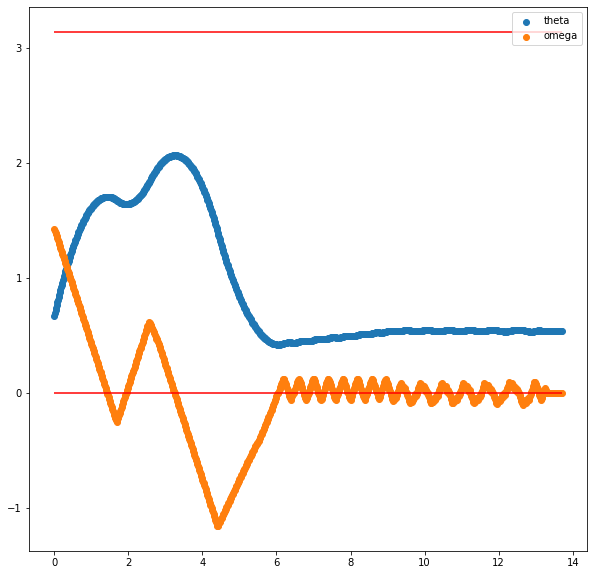

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()


In [11]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=13.70000000000026, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

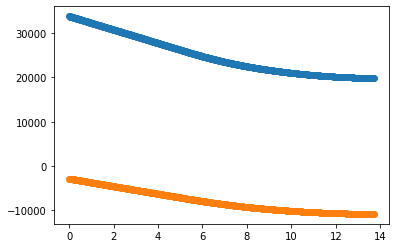

In [12]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

(70.0, 14.385000000000273)

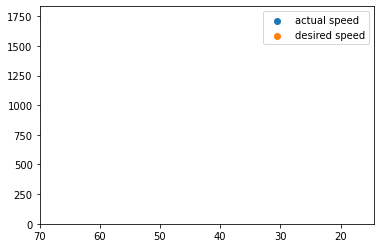

In [13]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.ylim(0)
plt.xlim(70)

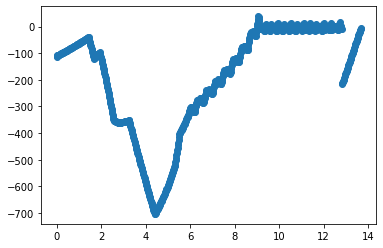

In [14]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])

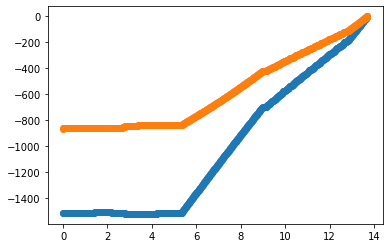

In [15]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

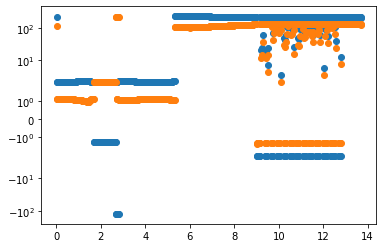

In [16]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")

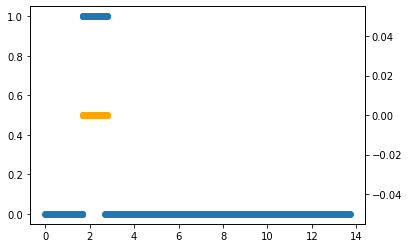

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [18]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=13.700000…

<function __main__.plot_collision_info(hist_length, max_time)>

(0.0, 14187.707426584062)

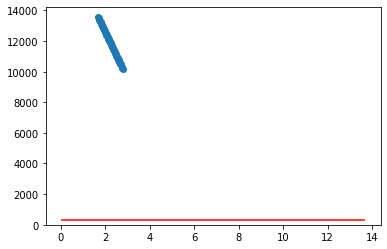

In [19]:
plt.scatter(df["ts"], df["o_ct_dist"])
plt.hlines(300, df["ts"].min(), df["ts"].max(), color="red")
plt.ylim(0)

In [20]:
if np.any(~df["o.ct"].isna()):
    df.groupby("o.ct")["ts"].describe()
else:
    print("no collision threats")

In [21]:
if np.any(~df["o.ct"].isna()):
    df.groupby("o.ct")["o_ct_dist"].describe()
else:
    print("no collision threats")

(903.3011826531382, 903.3011826531382)

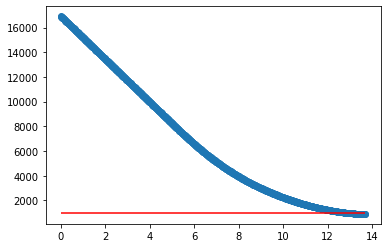

In [22]:
plt.scatter(df["ts"], df["o_t_dist"])
plt.hlines(1000, df["ts"].min(), df["ts"].max(), color="red")
df["o_t_dist"].min(),df[df["ts"] > df["ts"].max()-1]["o_t_dist"].min()

In [23]:
df[(df["ts"] >11.3)&(df["ts"]<11.4)]["o_t_dist"]

678    1513.548120
679    1505.920698
680    1498.362721
681    1490.874188
682    1483.455100
683    1476.105456
Name: o_t_dist, dtype: float64

In [24]:
if np.any(~df["o.t_loc"].isna()):
    df.groupby(["o.t_loc.x", "o.t_loc.y"])["ts"].describe().sort_values(["min"])

In [25]:
df.groupby(["o.t_loc.x", "o.t_loc.y"])["ts"].describe()

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
19117.170259,-11241.763871,822.0,6.841667,3.957254,0.0,3.420833,6.841667,10.2625,13.683333


In [26]:
df.groupby(["o.t_loc.x", "o.t_loc.y"])["o_t_dist"].describe()

,,count,mean,std,min,25%,50%,75%,max
o.t_loc.x,o.t_loc.y,,,,,,,,
19117.170259,-11241.763871,822.0,6706.694471,5013.931581,903.301183,2075.889691,5335.514248,10974.608265,16921.316914


In [27]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::20]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=13.700000…

<function __main__.plot_collision_chart(hist_length=13.70000000000026, max_time=13.70000000000026)>

In [28]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=13.700000…

<function __main__.plot_collision_chart(hist_length=13.70000000000026, max_time=13.70000000000026)>

In [29]:
df["v.x"].describe()

count    8.230000e+02
mean    -1.013510e+03
std      5.157366e+02
min     -1.520516e+03
25%     -1.511093e+03
50%     -1.167441e+03
75%     -5.334769e+02
max     -4.440892e-16
Name: v.x, dtype: float64

In [30]:
df["v.y"].describe()

count    823.000000
mean    -580.132517
std      283.666216
min     -865.000508
25%     -840.359172
50%     -676.310717
75%     -322.387749
max        0.000000
Name: v.y, dtype: float64

# 